## Importamos las bibliotecas a usar

In [1]:
import kagglehub
from PIL import Image, ImageOps
from itertools import islice
import glob
import matplotlib.pyplot as plt
import random
import torch
import numpy as np
import random
from PIL import Image 
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
from copy import deepcopy

In [2]:
device = torch.device("cpu")

<br>
<br>

## Descargamos Dataset

#### Creamos Lista con las rutas a todas las imagenes

En este caso tenemos las imagenes de $29$ peronas, y $13$ selfies
de cada una de estas, por lo que tendremos $377$ imagenes en total.

In [3]:
path = kagglehub.dataset_download("tapakah68/selfies-id-images-dataset")
print("Path to dataset files:", path)

# Solo usamos las selfies
IMAGE_FILES = glob.glob(path + "/**/Selfie*.jpg", recursive=True)
print('Numero de imagenes:', len(IMAGE_FILES))

Path to dataset files: /home/israncho/.cache/kagglehub/datasets/tapakah68/selfies-id-images-dataset/versions/5
Numero de imagenes: 377


<br>
<br>

La mayoria de los las imagenes tienen buena resolucion $2300 \times 3088$ pixeles, 
aunque no todos tiene las mismas dimensiones, y ademas son demasiado grandes para los fines
de este proyecto, razones por las cuales les realizaremos una reduccion de escala.

**Si se requiere ver el tamaño real de la imagen se debe descomentar la linea**

```python
#plt.figure(figsize=(width / DPI, height / DPI))
````

ruta del archivo:
 /home/israncho/.cache/kagglehub/datasets/tapakah68/selfies-id-images-dataset/versions/5/Selfies ID Images dataset/11_sets_Hispanics/0001cc1e1e--61af86f374501f072edf6d2c_age_22_name_Juliana/Selfie_11.jpg
Dimensiones: 2320 , 3088


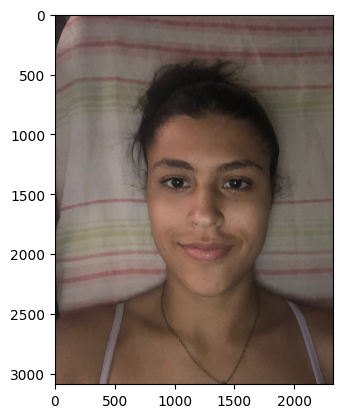

In [4]:
# Abrir la primera imagen
image = ImageOps.exif_transpose(Image.open(IMAGE_FILES[0]))
print('ruta del archivo:\n', IMAGE_FILES[0])
DPI = 96 # pixeles por pulgada
width, height = image.size
#plt.figure(figsize=(width / DPI, height / DPI))  # PARA VER EL TAMA~NO REAL hay que descomentar esta linea <--------------------------------------------
plt.imshow(image)
print('Dimensiones:', width, ',', height)

<br>
<br>

## Reduccion de escala

Si se descomento la linea mencionada se podra ver que en efecto es demasiado grande, por lo que trabajaremos las imagenes reducidas
estas seran de tama~no $100 \times 100$. 

nuevas dimensiones: 100 , 100


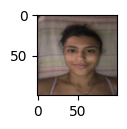

In [5]:
downscaled_width, downscaled_height = 100, 100
print('nuevas dimensiones:', downscaled_width, ',', downscaled_height)
downscaled_img = image.resize((downscaled_width, downscaled_height))
plt.figure(figsize=(downscaled_width / DPI, downscaled_height / DPI))
plt.imshow(downscaled_img)

<br>
<br>

## Creacion del dataset supervisado

Para facilitar la creacion del dataset con supervision primiero organizaremos
la lista con las rutas de las imagenes de una forma distinta.

Podemos notar que si dividimos las cadenas con respecto al caracter `/`
la penultima cadena siempre son los datos de la persona y nos puede
servir como identificador.

In [6]:
IMAGE_FILES[0].split('/')[-2]

'0001cc1e1e--61af86f374501f072edf6d2c_age_22_name_Juliana'

<br>
<br>

**Creamos un diccionario** donde las llaves son el id de la persona
y el valor es el indice de la imagen (en realidad es la ruta absoluta
en el sistema) dentro de

```python
IMAGE_FILES
```


In [7]:
def organized_dataset(image_files: list[str]) -> dict:
    dataset = {}
    for i, image_full_path in enumerate(image_files):
        person_id = image_full_path.split('/')[-2]
        if person_id not in dataset:
            dataset[person_id] = []
        dataset[person_id].append(i)
    return dataset
    
DATASET = organized_dataset(IMAGE_FILES)
print('Personas:', len(DATASET))

Personas: 29


In [8]:
def supervised_dataset(dataset: dict) -> tuple[list, list]:
    supervised_ds = []
    all_ids = set(dataset.keys())
    
    for person_id in dataset.keys():
        # computing matching_img, same person
        for img_j in dataset[person_id]:
            for img_k in dataset[person_id]:
                supervised_ds.append((img_j, img_k, 1))


        # computing mismatching_img, different person
        all_ids.remove(person_id) # temporary remove to compare with others
        for img_i in dataset[person_id]:
            for other_person_id in all_ids:
                mismatched_img = list(map(lambda x: (img_i, x, 0), dataset[other_person_id]))
                supervised_ds.extend(mismatched_img)
        all_ids.add(person_id)

    return supervised_ds
    
SUPERVISED_DATASET = supervised_dataset(DATASET)
print(len(SUPERVISED_DATASET))

142129


In [9]:
CLASS0 = list(filter(lambda x: x[2] == 0 , SUPERVISED_DATASET))
CLASS1 = list(filter(lambda x: x[2] == 1 , SUPERVISED_DATASET))

In [10]:
def show_imgs_side_to_side(path_img1: str, path_img2: str):
    img1 = ImageOps.exif_transpose(Image.open(path_img1))
    img2 = ImageOps.exif_transpose(Image.open(path_img2))
    
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    axes[0].imshow(img1)
    axes[0].axis('off')  # Desactivar los ejes
    axes[0].set_title("Imagen 1")
    
    axes[1].imshow(img2)
    axes[1].axis('off')  # Desactivar los ejes
    axes[1].set_title("Imagen 2")
    
    plt.tight_layout()
    plt.show()


<br>
<br>

### Ejemplo de dato de entrenamiento aleatorio de la clase 0 sin reducir

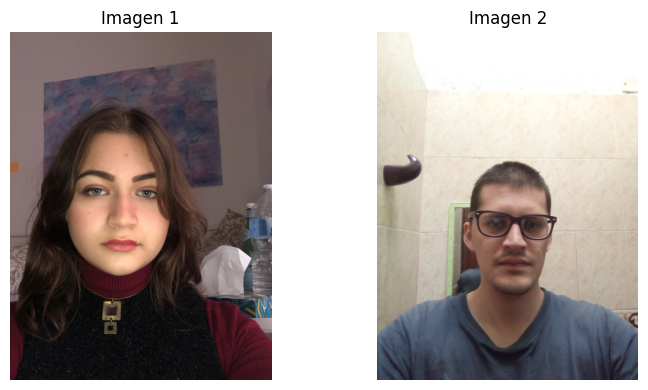

In [11]:
fst_img_i, snd_img_i, _ = random.choice(CLASS0)
show_imgs_side_to_side(IMAGE_FILES[fst_img_i], IMAGE_FILES[snd_img_i])

<br>
<br>

### Ejemplo de dato de entrenamiento aleatorio de la clase 1 sin reducir

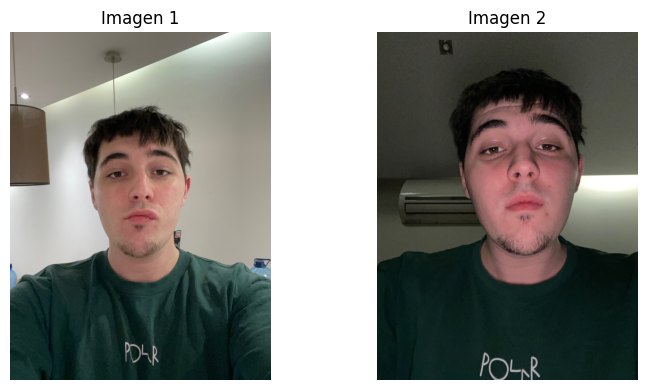

In [12]:
fst_img_i, snd_img_i, _ = random.choice(CLASS1)
show_imgs_side_to_side(IMAGE_FILES[fst_img_i], IMAGE_FILES[snd_img_i])

Una parte del codigo y guia del proyecto se baso por el trabajo de dataHacker en su video y repositorio.
Gracias por compartir este recurso, el cual fue de gran ayuda para el desarrollo de este modelo.

Lo que fue gran parte de su codigo fue en la visualizacion y procesamiento del dataset, aunque fue adaptado a nuestros datos.

repositorio: https://github.com/maticvl/dataHacker/blob/master/pyTorch/014_siameseNetwork.ipynb
video: https://www.youtube.com/watch?v=9hLcBgnY7cs&t=296s

In [13]:
#Reducimos los casos de la clase 0 para que sea parejo con la clase1 

class1_size = len(CLASS1)

CLASS0_SAMPLES = random.sample(CLASS0, class1_size)

data_train_indexes, data_eval_indexes = train_test_split(CLASS1 + CLASS0_SAMPLES, train_size=0.7)
print(data_train_indexes[:10])
print(data_eval_indexes[:10])
print('Tama~no dataset entrenamiento:', len(data_train_indexes))
print('Tama~no dataset evaluacion:', len(data_eval_indexes))

[(220, 211, 1), (133, 117, 0), (358, 332, 0), (215, 217, 1), (279, 222, 0), (271, 173, 0), (153, 371, 0), (42, 51, 1), (119, 119, 1), (186, 187, 1)]
[(261, 261, 1), (244, 245, 1), (190, 182, 1), (174, 181, 1), (234, 16, 0), (293, 298, 1), (153, 150, 1), (323, 280, 0), (149, 152, 1), (211, 5, 0)]
Tama~no dataset entrenamiento: 6861
Tama~no dataset evaluacion: 2941


In [14]:
#Funciones para mostrar imagenes obtenidas por dataHacker en su proyecto 014_siamseNEtwork
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [15]:
# Cambiamos el tamanno de las imagenes y las transformamos en tenseres
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

TRANFORMED_IMGS = []
for img_file_path in tqdm(IMAGE_FILES, desc="Transformando imagenes a tensores", leave=True):
    img = Image.open(img_file_path)
    img = ImageOps.exif_transpose(img).convert("RGB")
    TRANFORMED_IMGS.append(transformation(img))

Transformando imagenes a tensores:   0%|          | 0/377 [00:00<?, ?it/s]

In [16]:
class PreprocessedDataset(Dataset):
    def __init__(self, data: list[tuple], images):
        self.data = deepcopy(data) # no guardamos las imagenes, sino los tuplas con indices de posicion en IMAGE_FILES y TRANSFORMED_IMGS
        for i, (img1_i, img2_i, label) in enumerate(self.data):
            self.data[i] = img1_i, img2_i, torch.from_numpy(np.array([label], dtype=np.float32))
        self.images = images
        
    def __getitem__(self, index):
        img1_index, img2_index, label = self.data[index]
        img1 = self.images[img1_index] 
        img2 = self.images[img2_index] 
        return img1, img2, label
        
    def __len__(self):
        return len(self.data)


In [17]:
dataset_train = PreprocessedDataset(data_train_indexes, TRANFORMED_IMGS) #Para poder meterlo en dataloader
dataset_eval = PreprocessedDataset(data_eval_indexes, TRANFORMED_IMGS) #Para poder meterlo en dataloader

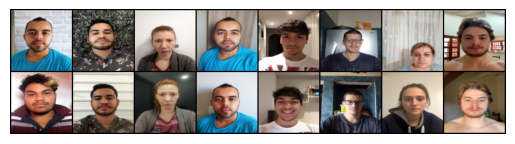

[0. 1. 1. 1. 1. 1. 0. 1.]


In [18]:

# Creamos un dataloader para visualizar los datos
vis_dataloader = DataLoader(dataset_train,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# tomamos un batche
example_batch = next(iter(vis_dataloader))

#Concatenamos los pares de imagen para visualizar los datos
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated, nrow=8, padding=2, normalize=True, scale_each=True))
print(example_batch[2].numpy().reshape(-1))

In [19]:
example_batch[0].shape

torch.Size([8, 3, 100, 100])

[ batch_size, canales RGB, tamanno de la imagen ]

In [20]:
# Creamos la red 
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        #Dividimos la red en dos partes una convolucional para pasar la imagen a un espacio de caracteristicas
        #en la que podamos obtener una distancia entre dos imagenes, donde si dos imagenes son de la 
        #misma persona entonces se encontraran cerca en el espacio es decir su distancia sera corta y viceversa.
        
        #En la parte convolucional extraemos caracteristicas de las imagenes

        # Capas convolucionales para obtener las caracteristicas de las imagenes
        #self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)  # 3 input porque es rgb el padding mantiene el output 100x100
        self.conv1 = nn.Conv2d(3, 8, kernel_size=7, stride=1, padding=3) 
        #64 filtros captura caracteristicas de bajo nivel como bordes y texturas
        
        #self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2)
        #128 filtros captura patrones mas complejos como formas y pequennas partes de la cara como ojos y narices
        
        
        #self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        #256 filtros captura carecteristicas de mas alto nivel y combinaciones de patrones

        #ir de 64 -> 128 -> 256 es un patron comun que nos asegura que la red tenga la capacidad de aprender caracteristicas cada vez
        #mas complejas mientras que se va reduciondo la imagen
        #Tener el kernel de tamanno 3x3 hace que capute a mejor detalle las caracteristicas 
        # Y el padding a 1 es para conservar las dimensiones espaciales despues de la convolucion
        
        # Max pool para reducir la dimension espacial
        self.pool = nn.MaxPool2d(2, 2) #despues del primer conv + pool ouput pasa de 3x100x100 a 64x50x50
        # en la segunda conv + pool output 128x25x25
        # en la ultima con + pool 256 x 12 x 12

        #El maxpool tamanno 2 y stride 2 reduce las dimensiones espaciales a la mitad, haciendo que el modelo sea mejor computable
        # Maxpooling mantinen las caracteristicas destacadas en la region, lo que hace que la red se enfoque en patrones importantes
        # mientas va descartando las menos relevantes



        #Las capas completamente conectadas toma las caracteristicas obtenidas en la parte cnn
        #y las convierte en una representacion compacta para poder compararse, el resultado de la ultima convolucion con pool es de
        # 256 x 12 x 12, tenemos que aplanarlo para meterlo en la primera capa de FCNN
        # 1024 es un buen tamano para empezar el embedding
        # Y al fina un vector de tamanno 124 es usualmente escogido para tener una buena representacion de la imagen especialmente para
        # face comparison
 
        self.fc1 = nn.Linear(32 * 12 * 12, 1024)  
        self.fc2 = nn.Linear(1024, 128)  
        #Obtenemos una representacion compacta de las caracteristicas de la imagen

        
    def forward_once(self, x):
        # Aplicamos la parte convolucional con relu y en cada una reducimos la dimension
        #F.relu es puramente funcional (no objeto) aplica directamente la activacion
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1) #Aplanamos el resultado para pasarla a la parte fully conneted 256 * 12 * 12 a 36864

         # Obtenemos el embedding
        x = F.relu(self.fc1(x))  #ReLU para que la red aprenda patrones mas complejos
        #fc1 linear toma las caracteristicas obtenidas por la parte convolucional y las procesa para tener caracteristicas de alto nivel
        x = self.fc2(x)  # fc2 linear da el vector final en este caso de tamanno 128 caracteristicas
        return x

    def forward(self, input1, input2):
        
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [21]:
#La parte importante de siamese networ
#Encontrar la distancia entre las dos imagenes dado el embeding obtenido 
class ContrastiveLoss(torch.nn.Module):
    #El margen es importante porque funciona respecto a nuestro dataset, como veo que son muy distinto, tal vez sea mejor aumentarlo
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculamos la distancia euclidiana entre los dos resultados y luego la perdida
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

        loss_positive = label * torch.pow(euclidean_distance, 2)  # For similar pairs
        loss_negative = (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)  #
        loss_contrastive = torch.mean(loss_positive + loss_negative)

        return loss_contrastive

In [22]:

# Load the training dataset
train_dataloader = DataLoader(dataset_train,
                        shuffle=True,
                        num_workers=8,
                        batch_size=32)


In [23]:
print(len(dataset_train))

6861


In [24]:
net = SiameseNetwork().to(device)
criterion = ContrastiveLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.0001 )

In [25]:
# Entrenamiento
counter = [] #Variable para poder graficar como cambia la perdida durante las epocas
loss_history = [] 
iteration_number= 0

for epoch in tqdm(range(5), desc="Entrenando", leave=True):
    print('Epoch', epoch, ' - loss history: ', end='')
    #img son tensoresn
    # itermos por batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):
        # Mandamos las imagenes al cpu
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        # Receteamos el gradiente 
        optimizer.zero_grad()

        # Pasamos las imagenes a la red 
        output1, output2 = net(img0, img1)

        # Calculamos la perdida 
        loss_contrastive = criterion(output1, output2, label)

        # Parte de aprendizaje 
        loss_contrastive.backward()

        # Optimizamos
        optimizer.step()

        # Para ver el proceso cada 10 batches (batch size 32)
        if i % 10 == 0 :
            print(f"{loss_contrastive.item():.3f}, ", end='')
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
    print()

Entrenando:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0  - loss history: 2.347, 1.969, 1.494, 1.136, 0.749, 0.983, 0.753, 0.579, 0.554, 0.538, 0.690, 0.624, 0.513, 0.686, 0.385, 0.416, 0.735, 0.488, 0.556, 0.689, 0.567, 0.572, 
Epoch 1  - loss history: 0.694, 0.445, 0.376, 0.541, 0.325, 0.480, 0.505, 0.339, 0.346, 0.404, 0.345, 0.296, 0.339, 0.296, 0.379, 0.368, 0.304, 0.342, 0.245, 0.271, 0.162, 0.194, 
Epoch 2  - loss history: 0.159, 0.284, 0.306, 0.234, 0.227, 0.224, 0.226, 0.216, 0.215, 0.215, 0.197, 0.174, 0.198, 0.087, 0.131, 0.297, 0.230, 0.180, 0.181, 0.113, 0.139, 0.096, 
Epoch 3  - loss history: 0.093, 0.105, 0.112, 0.153, 0.152, 0.152, 0.119, 0.144, 0.168, 0.123, 0.106, 0.047, 0.073, 0.087, 0.080, 0.064, 0.040, 0.060, 0.116, 0.063, 0.037, 0.046, 
Epoch 4  - loss history: 0.061, 0.058, 0.040, 0.071, 0.028, 0.022, 0.038, 0.040, 0.026, 0.043, 0.034, 0.081, 0.056, 0.035, 0.029, 0.043, 0.035, 0.021, 0.023, 0.071, 0.045, 0.064, 


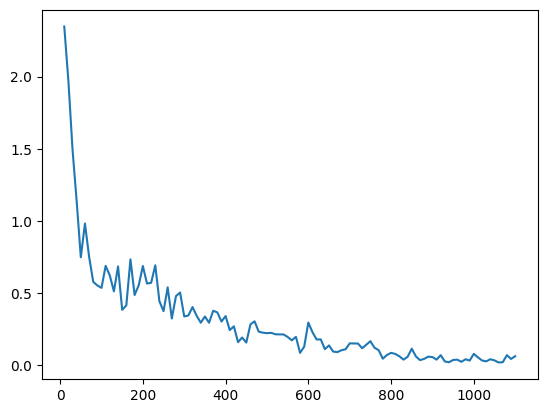

In [26]:
show_plot(counter, loss_history)

2941
tensor([[1.]])


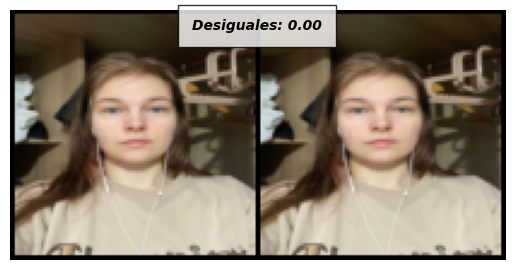

tensor([[1.]])


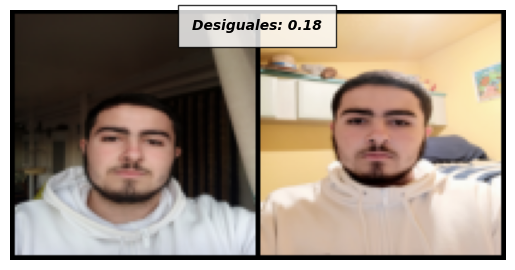

tensor([[1.]])


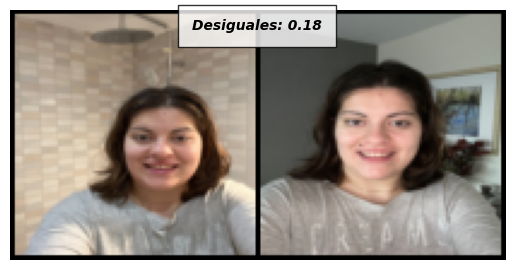

tensor([[1.]])


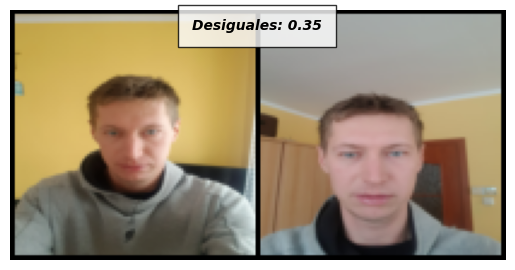

tensor([[0.]])


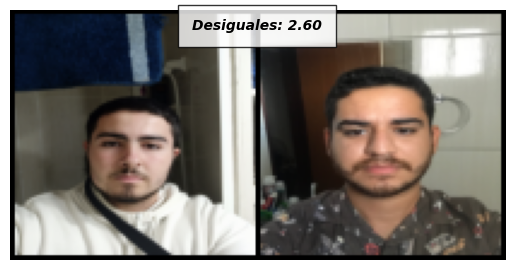

tensor([[1.]])


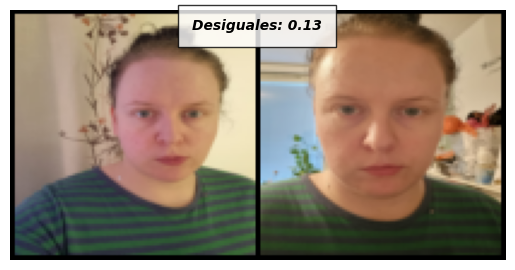

tensor([[1.]])


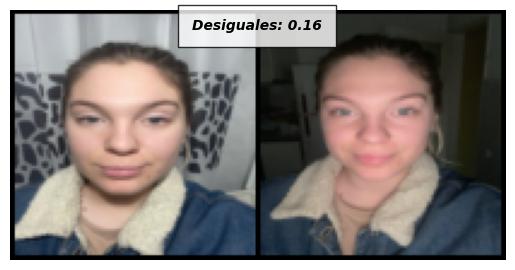

tensor([[0.]])


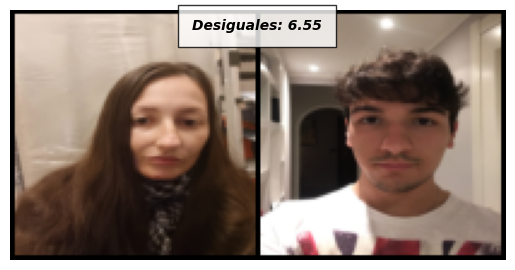

tensor([[1.]])


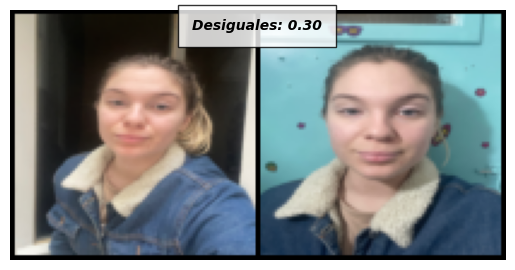

tensor([[0.]])


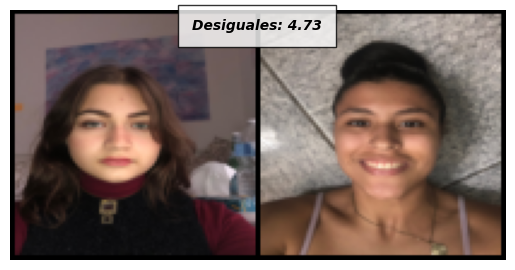

In [27]:
#Evaluamos 

eval_dataloader = DataLoader(dataset_eval, num_workers=2, batch_size=1, shuffle=False) #shuffle false para que no se pierda el orden de
# las etiquetas, al delimitar el tamanno de las CLASSES se tomaron de forma aleatoria entonces se puede decir que estan revueltas aun asi

#Sacamos una persona con distintas imagenes para ver que tan bien logra diferenciar
dataiter = iter(eval_dataloader)
#x0, _, _ = next(dataiter)
print(len(eval_dataloader))
for i in range(10):
    x0, x1, label2 = next(dataiter)
    print(label2)
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.to(device), x1.to(device))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Desiguales: {euclidean_distance.item():.2f}')

In [28]:
def distances_to_classes(distances):
    classes = []
    for distance in distances:
        if distance < 1.0:
            classes.append(1)
        else: 
            classes.append(0)
    return classes

In [29]:
distances = []
labels_eval = []
for i, (img0, img1, label) in enumerate(eval_dataloader, 0):
    output1, output2 = net(img0.to(device), img1.to(device))
    euclidean_distance = F.pairwise_distance(output1, output2)
    distances.append(euclidean_distance.item())
    labels_eval.append(int(label.item()))

In [30]:
y_pred = distances_to_classes(distances)

In [31]:
print(y_pred)

[1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 

In [32]:
print(classification_report(y_pred, labels_eval, target_names=['Class 0', 'Class 1'], zero_division=0))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      1474
     Class 1       1.00      1.00      1.00      1467

    accuracy                           1.00      2941
   macro avg       1.00      1.00      1.00      2941
weighted avg       1.00      1.00      1.00      2941

